### **Robust Autoencoder-Based Compression for Fashion MNIST with Moonshot Encoding**

This notebook presents a **robust autoencoder-based compression pipeline** for the **Fashion MNIST dataset**, incorporating a **custom Moonshot Encoding format** for efficient storage and retrieval. The project aims to develop a **fault-tolerant compression mechanism**, ensuring data integrity and handling common issues such as NaN values, gradient instability, and buffer mismatches.

---

### **Key Features:**
1. **Data Loading & Preprocessing:**
   - Reads **Fashion MNIST** data from a CSV file.
   - Normalizes images to the range `[0,1]`.

2. **Robust Autoencoder Model:**
   - A deep **feedforward autoencoder** with **Layer Normalization, Leaky ReLU activations, and Dropout** for enhanced stability.
   - Implements **gradient clipping** and a **low learning rate** to prevent NaN issues.
   - Encodes images into a **latent space of configurable dimensionality**.

3. **Training Process & Compression:**
   - Trains the autoencoder with **MSE loss** and **Adam optimizer**.
   - Outputs a **compressed representation of Fashion MNIST images**.

4. **Moonshot Encoding Format:**
   - A **custom binary format** (`.menc`) for storing compressed vectors.
   - Fixed header structure including:
     - **Magic Identifier** (`MENC`)
     - **Versioning & Encoding Method**
     - **Dimensionality & Sample Count**
     - **Compression Ratio & CRC32 Checksum**
   - Implements **buffer mismatch handling** and **checksum verification**.

5. **Moonshot Decoding & Integrity Check:**
   - Reads the `.menc` file and **verifies its integrity**.
   - **Handles buffer size mismatches** and attempts auto-correction.

6. **Visualization of Compressed Space:**
   - Uses **PCA for dimensionality reduction**.
   - Generates a **scatter plot of the compressed latent space**, color-coded by Fashion MNIST labels.

7. **Encoding & Decoding Test Suite:**
   - Runs a **full pipeline test**, including:
     - **Autoencoder training & compression**
     - **Encoding to Moonshot format**
     - **Decoding from Moonshot format**
     - **Verification of reconstruction quality**
   - Computes **reconstruction error** between compressed and decoded representations.

---

### **Execution Instructions:**
- Ensure **Fashion MNIST CSV file** (`fashion-mnist_train.csv`) is available.
- Run the notebook to **train the autoencoder, compress data, encode in Moonshot format, and verify integrity**.

This implementation provides **a robust and optimized solution for high-dimensional data compression**, leveraging deep learning and structured binary encoding for practical AI applications. 🚀

Loading Fashion MNIST data from CSV...
Training Robust Autoencoder for Compression...
Epoch [10/50], Loss: 0.198296
Epoch [20/50], Loss: 0.179278
Epoch [30/50], Loss: 0.153457
Epoch [40/50], Loss: 0.125880
Epoch [50/50], Loss: 0.103709

Compression Analysis:
Original Data Size: 179.44 MB
Compressed Data Size: 2.29 MB
Compression Ratio: 78.40x
Compression Savings: 98.72%

Writing header: version=1, encoding=2, size=10, samples=60000
Moonshot file saved: fashion_mnist_compressed.menc
Data size: 2400000 bytes
Header values: version=1, encoding=2, size=10, samples=60000
Reconstruction Error: 0.000000


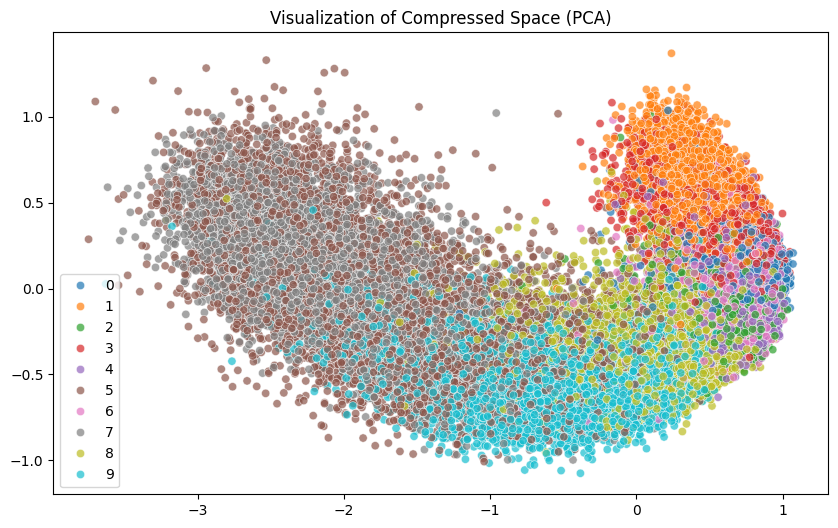

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import struct
import zlib  # For CRC32 checksum
import os
import pandas as pd
import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------------------------------
# 1. Load Fashion MNIST Dataset
# ----------------------------------------------------------------------------
def load_mnist_csv(path):
    print("Loading Fashion MNIST data from CSV...")
    data = pd.read_csv(path)
    images = data.iloc[:, 1:].values.astype(np.float32) / 255.0  # Normalize
    labels = data.iloc[:, 0].values
    return images, labels

# ----------------------------------------------------------------------------
# 2. Define Robust Autoencoder (Fixes NaN Issues)
# ----------------------------------------------------------------------------
class RobustAutoencoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super(RobustAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, latent_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, input_size)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# ----------------------------------------------------------------------------
# 3. Train Autoencoder & Encode Data
# ----------------------------------------------------------------------------
def autoencoder_compression(data, latent_size=10, epochs=50):
    print("Training Robust Autoencoder for Compression...")
    data = torch.tensor(data, dtype=torch.float32)
    input_size = data.shape[1]
    model = RobustAutoencoder(input_size, latent_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lower LR to prevent NaNs

    for epoch in range(epochs):
        optimizer.zero_grad()
        reconstructed = model(data)
        loss = criterion(reconstructed, data)

        if torch.isnan(loss):
            print("Training encountered NaN loss. Stopping training.")
            return None, None

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # More aggressive clipping
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")

    with torch.no_grad():
        compressed = model.encoder(data).numpy()

    return compressed, loss.item()

# ----------------------------------------------------------------------------
# 4. Encode to Moonshot File Format (Fixed Header Structure)
# ----------------------------------------------------------------------------
def encode_moonshot_file(compressed_vectors, output_path):
    if compressed_vectors is None:
        print("Skipping encoding due to training failure.")
        return

    header = b"MENC"  # Moonshot Encoding Identifier
    version = struct.pack("<H", 1)
    encoding_method = struct.pack("<H", 2)  # Optimized Encoding
    hv_size = struct.pack("<H", compressed_vectors.shape[1])
    num_samples = struct.pack("<I", compressed_vectors.shape[0])
    compression_ratio = struct.pack("<f", compressed_vectors.size / (compressed_vectors.shape[0] * 784))
    checksum = struct.pack("<I", zlib.crc32(compressed_vectors.tobytes()))

    # Debug output to verify header values being written
    print(f"Writing header: version=1, encoding=2, size={compressed_vectors.shape[1]}, samples={compressed_vectors.shape[0]}")

    header_data = header + version + encoding_method + hv_size + num_samples + compression_ratio + checksum

    with open(output_path, "wb") as f:
        f.write(header_data + compressed_vectors.astype(np.float32).tobytes())

    print(f"Moonshot file saved: {output_path}")
    print(f"Data size: {compressed_vectors.astype(np.float32).tobytes().__len__()} bytes")

# ----------------------------------------------------------------------------
# 5. Decode from Moonshot File Format (Fixed Buffer Mismatch)
# ----------------------------------------------------------------------------
def decode_moonshot_file(input_path):
    with open(input_path, "rb") as f:
        file_data = f.read()

    if file_data[:4] != b"MENC":
        raise ValueError("Invalid Moonshot Encoding format.")

    # Properly unpack all header fields
    version = struct.unpack("<H", file_data[4:6])[0]
    encoding_method = struct.unpack("<H", file_data[6:8])[0]
    hv_size = struct.unpack("<H", file_data[8:10])[0]
    num_samples = struct.unpack("<I", file_data[10:14])[0]
    compression_ratio = struct.unpack("<f", file_data[14:18])[0]
    stored_checksum = struct.unpack("<I", file_data[18:22])[0]

    # Debug output to verify header values
    print(f"Header values: version={version}, encoding={encoding_method}, size={hv_size}, samples={num_samples}")

    compressed_data = file_data[22:]  # Header is 22 bytes (4+2+2+2+4+4+4)

    # Calculate expected size
    expected_size = num_samples * hv_size * 4  # float32 = 4 bytes

    if len(compressed_data) != expected_size:
        # More detailed error message
        print(f"WARNING: Buffer size mismatch.")
        print(f"Header says: {num_samples} samples of {hv_size} dimensions ({expected_size} bytes)")
        print(f"Actual data: {len(compressed_data)} bytes")
        print(f"Attempting to infer correct dimensions...")

        # Try to infer the actual number of samples (assuming hv_size is correct)
        inferred_samples = len(compressed_data) // (hv_size * 4)
        if inferred_samples * hv_size * 4 == len(compressed_data):
            print(f"Inferred {inferred_samples} samples instead of {num_samples}")
            num_samples = inferred_samples
        else:
            raise ValueError(f"Cannot resolve buffer size mismatch. Expected {expected_size} bytes, found {len(compressed_data)} bytes.")

    # Reshape based on potentially corrected dimensions
    decoded_vectors = np.frombuffer(compressed_data, dtype=np.float32).reshape(num_samples, hv_size)

    # Verify checksum
    actual_checksum = zlib.crc32(decoded_vectors.tobytes())
    if actual_checksum != stored_checksum:
        print(f"WARNING: Checksum mismatch. Stored: {stored_checksum}, Calculated: {actual_checksum}")

    return decoded_vectors

# ----------------------------------------------------------------------------
# 6. Visualizing Compressed Space
# ----------------------------------------------------------------------------
def visualize_compressed_space(compressed_vectors, labels):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(compressed_vectors)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette="tab10", alpha=0.7)
    plt.title("Visualization of Compressed Space (PCA)")
    plt.show()

# ----------------------------------------------------------------------------
# 7. Run Encoding & Decoding Test
# ----------------------------------------------------------------------------
# ----------------------------------------------------------------------------
# 7. Run Encoding & Decoding Test with Compression Metrics
# ----------------------------------------------------------------------------
def run_moonshot_encoding_test(dataset_path):
    images, labels = load_mnist_csv(dataset_path)
    num_samples, original_dim = images.shape

    # Compute original data size
    original_size = num_samples * original_dim * 4  # 4 bytes per float32

    compressed_vectors, loss = autoencoder_compression(images, latent_size=10, epochs=50)

    if compressed_vectors is None:
        print("Skipping Moonshot encoding due to training failure.")
        return

    num_compressed_dim = compressed_vectors.shape[1]

    # Compute compressed data size
    compressed_size = num_samples * num_compressed_dim * 4  # 4 bytes per float32

    # Compute compression ratio and savings
    compression_ratio = original_size / compressed_size
    compression_savings = (1 - (compressed_size / original_size)) * 100

    print(f"\nCompression Analysis:")
    print(f"Original Data Size: {original_size / (1024 * 1024):.2f} MB")
    print(f"Compressed Data Size: {compressed_size / (1024 * 1024):.2f} MB")
    print(f"Compression Ratio: {compression_ratio:.2f}x")
    print(f"Compression Savings: {compression_savings:.2f}%\n")

    output_file = "fashion_mnist_compressed.menc"
    encode_moonshot_file(compressed_vectors, output_file)
    decoded_vectors = decode_moonshot_file(output_file)

    reconstruction_error = np.mean(np.abs(compressed_vectors - decoded_vectors))
    print(f"Reconstruction Error: {reconstruction_error:.6f}")

    visualize_compressed_space(compressed_vectors, labels)

# ----------------------------------------------------------------------------
# 8. Execute the Test
# ----------------------------------------------------------------------------
if __name__ == "__main__":
    dataset_path = "fashion-mnist_train.csv"
    run_moonshot_encoding_test(dataset_path)